In [1]:
# PTT title generator from content base on seq2seq model.
import pandas as pd
import numpy as np
import csv
import os
import types 

#Initialize for files name and path.
base_dir = 'C:/Users/User/Raw data/PTT'
totalboard_name = 'TJ-BG-AT-SX-CC-MV'
board_name = ['Tech_job','Boy-Girl','AllTogether','sex','C_Chat','movie']
board_dict_index = {'Tech_job':0,'Boy-Girl':1,'AllTogether':2,'sex':3,'C_Chat':4,'movie':5}

max_word_length = 250
min_word_length = 100
max_title_length = 20 + 2
label_newnum = len(board_name)

GO_id = '<go>' #解碼器端的句子起始標識符。
EOS_id = '<eos>' #解碼器端的句子結束標識符。
UNK_id = '<unk>' #低頻詞或者一些未遇到過的詞等。
PAD_id = '<pad>' #補全字符。

new_content_dir = []
totalboard_dir = os.path.join(base_dir, totalboard_name)
if not os.path.exists(totalboard_dir):
    os.makedirs(totalboard_dir)
for name_ind in range(len(board_name)):
    # New data path
    new_content_dir.append(os.path.join(totalboard_dir, board_name[name_ind]+'_content'))
    if not os.path.exists(new_content_dir[name_ind]):
        os.makedirs(new_content_dir[name_ind])

from keras.preprocessing.sequence import pad_sequences
from sklearn.cross_validation import train_test_split
import jieba

# Import dictionary fron jieba and PTT.
jieba.set_dictionary('C:/Users/User/Anaconda3/Lib/site-packages/jieba/dict.txt.big')
jieba.load_userdict('C:/Users/User/Anaconda3/Lib/site-packages/jieba/userdict.txt')

text_content = []
text_label = []
text_generator = []

# Load PTT content and information.
dfs_total = pd.read_csv(os.path.join(totalboard_dir, totalboard_name + '.csv'))
len_total = len(dfs_total)

for dfs_index in range(len_total):
    read_index = int(dfs_total.iloc[dfs_index, 0])
    type_name = str(dfs_total.iloc[dfs_index, 1])
    word_length = int(dfs_total.iloc[dfs_index, 5])
    title_name = str(dfs_total.iloc[dfs_index, 9])
    this_board_name = str(dfs_total.iloc[dfs_index, 10])
    
    # Add start and end character.
    text = GO_id + ' '
    with open(os.path.join(new_content_dir[board_dict_index[this_board_name]], str(read_index) + '.csv'),
                'r', encoding = 'utf-8-sig') as file:
        csvCursor = csv.reader(file)
        for rows in csvCursor:
            for row in rows:
                # Read content and remove empty.
                text = text + row.lower()
        else:
            text = text + ' ' + EOS_id
    
    # Split titles to words by Jieba.
    title_name.encode('utf-8-sig')
    title_jieba = jieba.cut(title_name, cut_all=False)
    title_name = GO_id
    word_length = 0
    for word in title_jieba:
        word_length += 1
        title_name = title_name + ' ' + word.lower()
    else:
        title_name = title_name + ' ' + EOS_id
    
    text_content.append(text)
    text_label.append(board_dict_index[this_board_name])
    text_generator.append(title_name)
    file.close()

# Load vocabulary information.
with open(os.path.join(totalboard_dir, 'vocab.json') , 'r', encoding='utf-8-sig') as f_text:
    vocab = eval(f_text.read())
with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'r', encoding='utf-8-sig') as f_text:
    vocab_reverse = eval(f_text.read())
with open(os.path.join(totalboard_dir, 'vocab_sort.json') , 'r', encoding='utf-8-sig') as f_text:
    vocab_sort = eval(f_text.read())
#with open(os.path.join(totalboard_dir, 'vocab_counts.json') , 'r', encoding='utf-8-sig') as f_text:
    #vocab_counts = eval(f_text.read())
with open(os.path.join(totalboard_dir, 'vocab_docs.json') , 'r', encoding='utf-8-sig') as f_text:
    vocab_docs = eval(f_text.read())
vocab_size = len(vocab)

# Build vocabulary and convert content to sequence by Keras tool.
x_train, x_test, y_train, y_test = train_test_split(text_content, text_generator, test_size=0.2, random_state=9487)

filters_char='!"#$%&()*+,×-./:;=?@[\\]^_`{|}~\t\n　，。！：；、？＜＞﹝﹞「」『』（）｛｝［］【】《》〖〗﹙﹚“”‘’＼﹨｜〝〞‵′＋－＊／＝≦≧＿＠＃＄％⌒‿︵︷︹︻︽︿﹁﹃︶︸︺︼︾﹀﹂﹄＆～§◎．˙※ㄧ↔│ꄊ✂☁☛✈♥○●☆★◇◆□■▽▼△▲㊣⊙⊕ˍ…﹌﹋﹎﹍﹉﹊‥–↑↓←→↖↗↙↘∥∕℅≒≡∩∪∞￣＿◤◥◣◢∵∴〒⊥∠⊿┼┴┬┤├▔─│▕┌┐└┘╭╮╰╯═╞╪╡╔╦╗╠╬╣╚╩╝╒╤╕╘╧╛╓╥╖╟╫╢╙╨╜║▓░▒╱╲╳▁━▶▁▂▃▄▅▆▇█▉▊▋▋▌▍▎▏▐▔■▁▔' 
# Convert texts list to sequences list.
def texts_to_sequences(text_list):
    sequences_list = []
    for text in text_list:
        words = text.split(' ')
        sequence = []
        for word in words:
            if filters_char.find(word)>=0:
                continue
            elif word in vocab:
                sequence.append(vocab[word])
            else:
                sequence.append(vocab[UNK_id])
        sequences_list.append(sequence)
    return sequences_list

# 將單字轉換成字庫的索引值
x_train_word_ids = texts_to_sequences(x_train)
x_test_word_ids = texts_to_sequences(x_test)
y_train_word_ids = texts_to_sequences(y_train)
y_test_word_ids = texts_to_sequences(y_test)
# 序列模式
x_train = pad_sequences(x_train_word_ids, maxlen=max_word_length, padding='post', truncating='post')
x_test = pad_sequences(x_test_word_ids, maxlen=max_word_length, padding='post', truncating='post')
y_train = pad_sequences(y_train_word_ids, maxlen=max_title_length, padding='post', truncating='post')
y_test = pad_sequences(y_test_word_ids, maxlen=max_title_length, padding='post', truncating='post')
np.minimum(x_train, vocab[UNK_id], x_train)
np.minimum(x_test, vocab[UNK_id], x_test)
np.minimum(y_train, vocab[UNK_id], y_train)
np.minimum(y_test, vocab[UNK_id], y_test)
# 序列長度
x_train_size = [len(word_ids) for word_ids in x_train_word_ids]
x_test_size = [len(word_ids) for word_ids in x_test_word_ids]
y_train_size = [len(word_ids) for word_ids in y_train_word_ids]
y_test_size = [len(word_ids) for word_ids in y_test_word_ids]

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Building prefix dict from C:\Users\User\Anaconda3\Lib\site-packages\jieba\dict.txt.big ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.ufa6ae29b0cbce8b45e006c7fa30eaaf8.cache
Loading model cost 1.104 seconds.
Prefix 


epoch1
Iteration 206(9.93%); Train loss: 5.144587220540976 (std: 0.9394795223232509); run time: 461[s]
Iteration 412(19.91%); Train loss: 3.871109722306335 (std: 0.3440813208764952); run time: 921[s]
Iteration 618(29.89%); Train loss: 3.4568926054796365 (std: 0.31162624827945884); run time: 1379[s]
Iteration 824(39.87%); Train loss: 3.1695933952172797 (std: 0.2905074657508964); run time: 1835[s]
Iteration 1030(49.85%); Train loss: 2.9674666597107677 (std: 0.30485118442697573); run time: 2295[s]
Iteration 1236(59.84%); Train loss: 2.801034373301259 (std: 0.27141603027603467); run time: 2753[s]
Iteration 1442(69.82%); Train loss: 2.6807822457395014 (std: 0.27955266055738937); run time: 3211[s]
Iteration 1648(79.8%); Train loss: 2.5814505453161445 (std: 0.26697867053700647); run time: 3670[s]
Iteration 1854(89.78%); Train loss: 2.5429024944367833 (std: 0.29075545348413545); run time: 4132[s]
Iteration 2060(99.76%); Train loss: 2.440273433680556 (std: 0.2361172471355936); run time: 4588[s

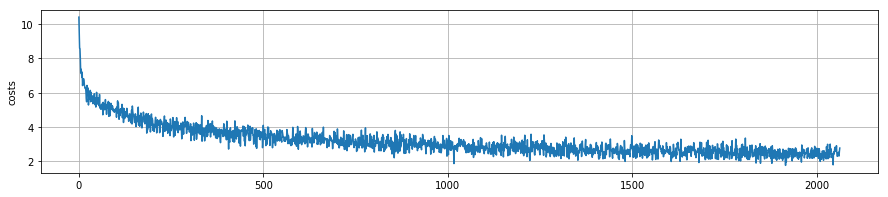

Target: <go><unk>與<unk><eos> Return: <go>拜託太嚴重會不會被嚴重<eos>
Target: <go>同公司的兩個職缺選擇<eos> Return: <go>一起玩桌遊吧<eos>
Target: <go>友達vs<unk><eos> Return: <go>關於offer<eos>
Target: <go>7年級生請進<eos> Return: <go>a片騎ア跟朋友<unk>回憶ア全裸<unk><eos>
Target: <go>大家都怎麼告訴伴侶我要射了<eos> Return: <go><unk>拿該要的一些出來<eos>
Target: <go>吃吃的愛<eos> Return: <go>雞雞動畫可以<unk><eos>
Target: <go>彼此的想法不同<eos> Return: <go><unk><unk>全裸<unk>協會<unk>推出<eos>
Target: <go>日本社會文化現象的觀察筆記1<eos> Return: <go>想請各位<unk>有關問題<eos>
Target: <go>茫茫人海遇見妳<eos> Return: <go>吃到人氣推出<eos>
Target: <go>緯創機構<eos> Return: <go><go>為何只做的不做<unk><eos>
Elapsed time in epoch 1: 4599 [s]

epoch2
Iteration 206(9.93%); Train loss: 2.3816978071124635 (std: 0.2670899596146604); run time: 458[s]
Iteration 412(19.91%); Train loss: 2.337262210127251 (std: 0.2509208672987334); run time: 917[s]
Iteration 618(29.89%); Train loss: 2.393815582610419 (std: 0.2687600424082545); run time: 1371[s]
Iteration 824(39.87%); Train loss: 2.317222477392914 (std: 0.24194014274202938); run time:

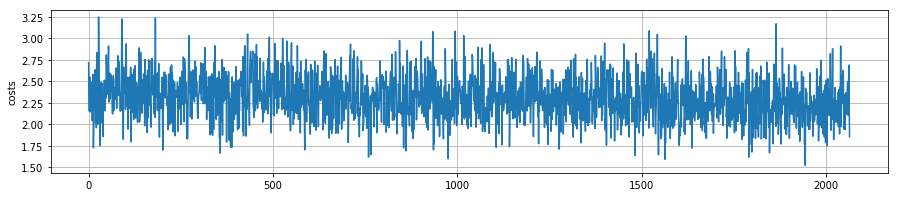

Target: <go>就再給自己一次機會<eos> Return: <go><go>2快<unk>了<eos>
Target: <go>不知道有沒有機會<eos> Return: <go>為什麼t手遊的<unk>都很歌<eos>
Target: <go>寧可娶婊做妻<eos> Return: <go>男18打手槍<eos>
Target: <go>一口氣把re動畫看完的結果<eos> Return: <go><unk>的作品中人<unk><eos>
Target: <go>x戰警<unk>教授的心態<eos> Return: <go>高雄的妳<eos>
Target: <go>台北假日晚餐<eos> Return: <go><unk><unk>小姐04<eos>
Target: <go>彈丸論破3絕望篇07<unk>姊唱的bgm<eos> Return: <go>大如果妻的的<unk>在哪<eos>
Target: <go>該老實說薪水嗎<eos> Return: <go><unk><unk>製程工程師<eos>
Target: <go>寄生獸<unk>預告<eos> Return: <go>妳會告白失敗<eos>
Target: <go><unk>男女<unk>屋頂來<unk>激情不復回<eos> Return: <go>請問大家對只有為的定義是什麼<eos>
Elapsed time in epoch 2: 4585 [s]

epoch3
Iteration 206(9.93%); Train loss: 2.1978059277570856 (std: 0.23874556542988606); run time: 458[s]
Iteration 412(19.91%); Train loss: 2.1970668442306676 (std: 0.2382080826256506); run time: 917[s]
Iteration 618(29.89%); Train loss: 2.188873264555644 (std: 0.2466921293064387); run time: 1373[s]
Iteration 824(39.87%); Train loss: 2.193964354618865 (std: 0.23536125448

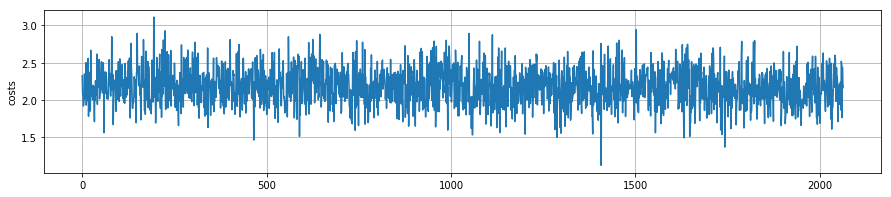

Target: <go>凱特布蘭琪獲女性影人成就獎<eos> Return: <go>洨的失戀<eos>
Target: <go>希德尼亞的騎士九星戰09<eos> Return: <go><unk>棒球911<eos>
Target: <go>跟高雄靈活小胖胖交個朋友吧<eos> Return: <go><unk>研發工程師<eos>
Target: <go>農夫想認識妳<eos> Return: <go>食戟之靈第的<unk><unk><eos>
Target: <go><unk>和宵夜早餐<eos> Return: <go><unk>支線世界看見的<unk><eos>
Target: <go>拜拜<unk>不能打手槍<eos> Return: <go>好萊塢ic轉中國市場搞頭<eos>
Target: <go>日月光歐美區美國<unk>管理<eos> Return: <go>有沒有人被摩鐵兩天砲的行為下來天母<eos>
Target: <go>請問胸部上面有小<unk>><<eos> Return: <go>jojo<unk><unk>我到底看了工程師<eos>
Target: <go>年後轉職科技業<unk>夢幻名單台積電<eos> Return: <go>ps4<unk>只是<unk>實驗室研究助理<eos>
Target: <go><unk>女角<eos> Return: <go>魔法<unk>的摩鐵<eos>
Elapsed time in epoch 3: 4616 [s]

epoch4
Iteration 206(9.93%); Train loss: 2.091720888146044 (std: 0.2618899810282126); run time: 465[s]
Iteration 412(19.91%); Train loss: 2.077134618537713 (std: 0.24895625441200483); run time: 923[s]
Iteration 618(29.89%); Train loss: 2.0875124750622915 (std: 0.27769667516361035); run time: 1380[s]
Iteration 824(39.87%); Train loss: 2.09035

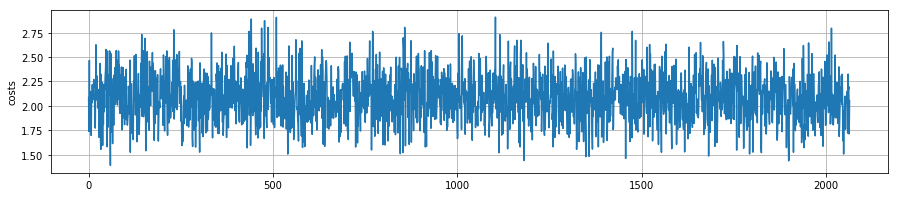

Target: <go>下一步該怎麼做呢<eos> Return: <go>台中健身<eos>
Target: <go>一文<unk><eos> Return: <go>星期六業嫌ド<eos>
Target: <go>一個人夜店<eos> Return: <go>刺客<unk>到爆吧投<eos>
Target: <go>星座<unk><eos> Return: <go>明天晚上午後表達聽<unk><eos>
Target: <go>對好朋友的感覺不一樣了<unk><eos> Return: <go>報告究竟7<unk><eos>
Target: <go><unk>創新創業激勵計畫免費創業講座<eos> Return: <go>男生都喜歡比自己單獨的女生嗎<eos>
Target: <go>女友一直嫌我胖超不爽<eos> Return: <go>你好你有她<eos>
Target: <go>只是想認識大家進來看看不用錢<eos> Return: <go>要怎樣的男生的想法<eos>
Target: <go>這婊子都可以上封面<eos> Return: <go>要怎麼一同尋求打算表達的正妹女友<eos>
Target: <go>高捷少女<unk>為<unk>拍宣導片配音<unk>崩<eos> Return: <go>一個瘋狂的想法可能<unk>科技業<eos>
Elapsed time in epoch 4: 4592 [s]

epoch5
Iteration 206(9.93%); Train loss: 2.0167407575081993 (std: 0.23386504923719353); run time: 455[s]
Iteration 412(19.91%); Train loss: 2.0236041687102087 (std: 0.2580098095362793); run time: 913[s]
Iteration 618(29.89%); Train loss: 2.000179613356511 (std: 0.23452004074106736); run time: 1371[s]
Iteration 824(39.87%); Train loss: 2.0522751141265254 (std: 0.2448592345185

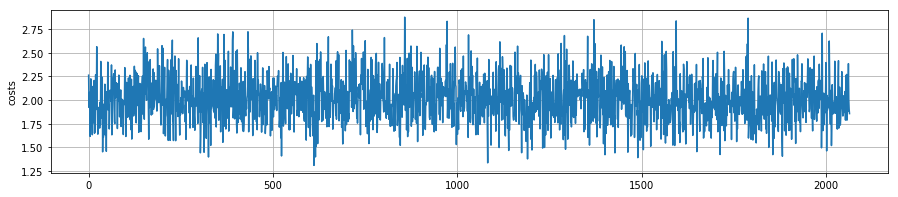

Target: <go>中國可憐伴娘遭新郎猥褻<unk>揉敏感帶<eos> Return: <go>末日之戰小溫馨溫馨的溫馨<eos>
Target: <go>中壢<unk>問題請教<eos> Return: <go><go>的逛最好<eos>
Target: <go>關於<unk>與剃毛<eos> Return: <go>熊語言<unk><eos>
Target: <go>台南懶散的一天從喝咖啡開始<eos> Return: <go>伊殭屍現場<eos>
Target: <go>一起走過的<unk>天<eos> Return: <go>有沒有面試沒<unk>人資的<eos>
Target: <go><unk>姊妹03<eos> Return: <go><unk><unk>04<eos>
Target: <go>想要<unk>的來的女孩<eos> Return: <go>熊好像<unk><eos>
Target: <go>在<unk>亂晃<eos> Return: <go>恐怖戰士的<unk><unk><unk><eos>
Target: <go>女友的身體狀況該生氣嗎<eos> Return: <go>與<unk>朋友的情況<eos>
Target: <go>鹹<unk><unk>自爆和老公吵架完馬上做愛<eos> Return: <go><unk>關係或好看的錢櫃片或喔片<eos>
Elapsed time in epoch 5: 4592 [s]

epoch6
Iteration 206(9.93%); Train loss: 1.9082507030145748 (std: 0.22172560029745914); run time: 462[s]
Iteration 412(19.91%); Train loss: 1.965726775536606 (std: 0.2304051822626919); run time: 924[s]
Iteration 618(29.89%); Train loss: 2.015773955793124 (std: 0.2182849189015623); run time: 1391[s]
Iteration 824(39.87%); Train loss: 1.9820514827404383 (std: 0.

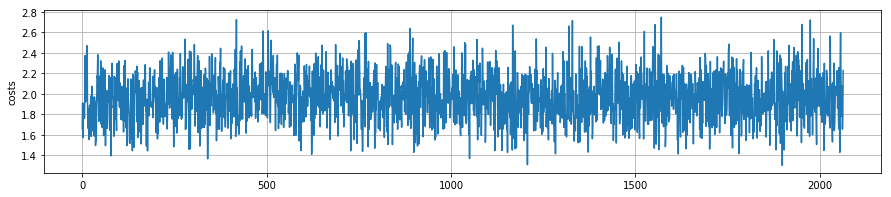

Target: <go>史傳奇的魔術秀<eos> Return: <go>天氣分開<unk>新竹桃園苗栗女交往<eos>
Target: <go>女朋友這樣的問題跟回答代表什麼<eos> Return: <go>高工時的工作大家逮多久<eos>
Target: <go>看電影吃個飯都好<eos> Return: <go><unk>人生<unk><unk><eos>
Target: <go>處女會痛<eos> Return: <go><go>啦a夢惹<unk><unk><unk><unk><eos>
Target: <go>關於女朋友的前男友<eos> Return: <go><go>一直<go>會不會黑漆漆<eos>
Target: <go>交往後就可以比較不回訊息<eos> Return: <go>明天晚上1128台北完成<eos>
Target: <go><unk>看動漫<eos> Return: <go>鴻海有限公司<go>祝福<go>出演出演<eos>
Target: <go>殤不患幹嘛<unk><unk><unk><eos> Return: <go>尋找願意真心技巧西斯的女生<unk><eos>
Target: <go><unk>了快打旋風v一口氣公布小櫻<eos> Return: <go>關鍵北美出演黑漆漆的片子女性讓人<unk><eos>
Target: <go><unk><eos> Return: <go>加班費<unk>橋段警探嗎ミ06名單<eos>
Elapsed time in epoch 6: 4588 [s]

epoch7
Iteration 206(9.93%); Train loss: 1.8958585157999608 (std: 0.22848619086808397); run time: 453[s]
Iteration 412(19.91%); Train loss: 1.9175978783973202 (std: 0.2423210896270904); run time: 905[s]
Iteration 618(29.89%); Train loss: 1.934892787269014 (std: 0.23297984311704326); run time: 1359[s]
Iteration 824(39.8

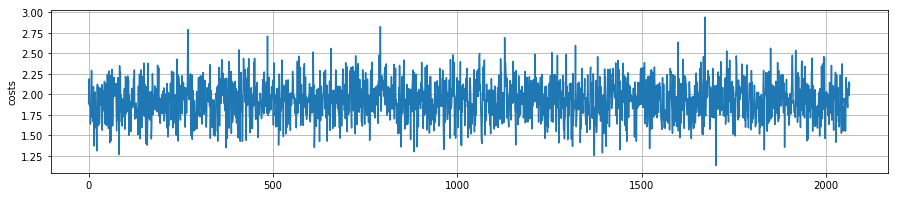

Target: <go>為什麼宙斯不在天堂<unk>幾個<eos> Return: <go>來之前特別不<eos>
Target: <go><unk>神鬼獵人<unk><unk>奧斯卡<eos> Return: <go><unk>先進<unk>有限公司相關問題<eos>
Target: <go>offer請益欣興<eos> Return: <go>動漫14的正宮年紀<unk>是誰<eos>
Target: <go><unk><unk><unk>搞機車合約男女讓鄭<eos> Return: <go>異形2<unk><unk><go>大演員<eos>
Target: <go>前女友<eos> Return: <go>好朋友話題結婚<eos>
Target: <go><unk>觸控面板<eos> Return: <go>公司請你下班後去<unk><eos>
Target: <go>大家吃過哪家公司的伙食最好呢<eos> Return: <go>妹子<go><unk>改<unk><eos>
Target: <go>高雄寫程式薪資這樣是正常的嗎<eos> Return: <go>安開發工程師<eos>
Target: <go>有沒有艦娘都不洗澡的<unk><eos> Return: <go>翡翠業面試製不同缺創機會<eos>
Target: <go>忘記全程使用保險套<eos> Return: <go><unk>我不是的的幸運<eos>
Elapsed time in epoch 7: 4540 [s]

epoch8
Iteration 206(9.93%); Train loss: 1.874817326692104 (std: 0.22119768087493713); run time: 453[s]
Iteration 412(19.91%); Train loss: 1.8942247146205209 (std: 0.25570575437063947); run time: 904[s]
Iteration 618(29.89%); Train loss: 1.9173531020457855 (std: 0.22035381510178062); run time: 1357[s]
Iteration 824(39.87%); Train loss: 1.9

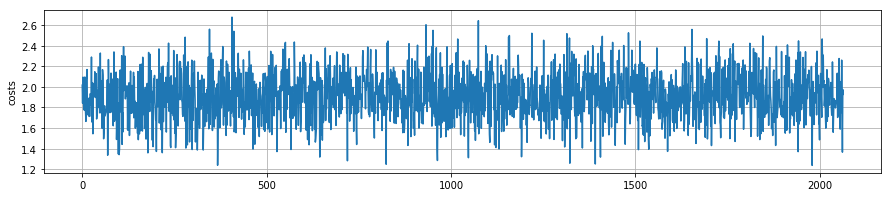

Target: <go>洨智告別處男<eos> Return: <go>今日<go><unk>19<eos>
Target: <go>關於世界末日的大爛片<eos> Return: <go><unk>是不是很忘不了<eos>
Target: <go>台南一起從朋友開始校園運動散步<eos> Return: <go>妖怪研發工程師<eos>
Target: <go>聊天互相鼓勵的夥伴<eos> Return: <go>想聖誕說服忘不了另一半給我<eos>
Target: <go>就再給自己一次機會<eos> Return: <go>關於昨天的事件<eos>
Target: <go>明日屏東里<unk><eos> Return: <go><unk>真的比<unk><unk><unk><eos>
Target: <go>男生到底該不該<unk><eos> Return: <go>東離劍す<unk>界<unk><eos>
Target: <go>為什麼<unk>一拳超人的進度比one慢<eos> Return: <go>人資可以配角給調薪主管<eos>
Target: <go>現實中有雙馬尾嗎<eos> Return: <go>日本課程調薪實習生釋出か的歌曲年小說<eos>
Target: <go>湯姆<unk>挺最高衝擊埃及上映開<eos> Return: <go>台北走走<eos>
Elapsed time in epoch 8: 4540 [s]

epoch9
Iteration 206(9.93%); Train loss: 1.8880112586700954 (std: 0.22701490377096295); run time: 455[s]
Iteration 412(19.91%); Train loss: 1.8848672860952658 (std: 0.2386477037815105); run time: 907[s]
Iteration 618(29.89%); Train loss: 1.872078380697629 (std: 0.23566505511227812); run time: 1360[s]
Iteration 824(39.87%); Train loss: 1.9022207757341592 (std: 0.22

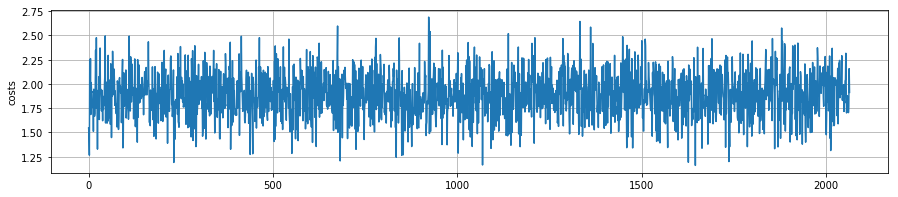

Target: <go>貓咪收藏真人電影版日本<unk>日上映<eos> Return: <go>猜角色<eos>
Target: <go>科技業中年的定義<eos> Return: <go>為了完美11av女優一天做愛18小時<eos>
Target: <go>地獄戀第二部08教訓地獄<eos> Return: <go>7月1<unk>好多有好多<unk>玩棒棒展<eos>
Target: <go>真的該結束了<eos> Return: <go>約砲高手<eos>
Target: <go>台中徵友<eos> Return: <go>offer選擇美光友達<eos>
Target: <go>騎乘位到底怎麼<unk><eos> Return: <go>祝喝咖啡匿名條件不得來<eos>
Target: <go>新竹未來的另一半<eos> Return: <go>部分<unk>玩家愛語言是有歷史淫的<eos>
Target: <go>尋找未知的另一半<eos> Return: <go>女友挽回<go>室友的禮物<eos>
Target: <go>山繆傑克森練中文ng曝光邀粉絲聊新片<eos> Return: <go>第一份工作公司的選擇<eos>
Target: <go><unk>國際影展放映台片<unk><eos> Return: <go><unk>億<unk>我們真的被迫大雷<eos>
Elapsed time in epoch 9: 4543 [s]

epoch10
Iteration 206(9.93%); Train loss: 1.838016042310452 (std: 0.25454009486599943); run time: 454[s]
Iteration 412(19.91%); Train loss: 1.8731825862846563 (std: 0.23657409402533094); run time: 904[s]
Iteration 618(29.89%); Train loss: 1.8919616292438306 (std: 0.21806406020888733); run time: 1355[s]
Iteration 824(39.87%); Train loss: 1.8830882815023005 (std:

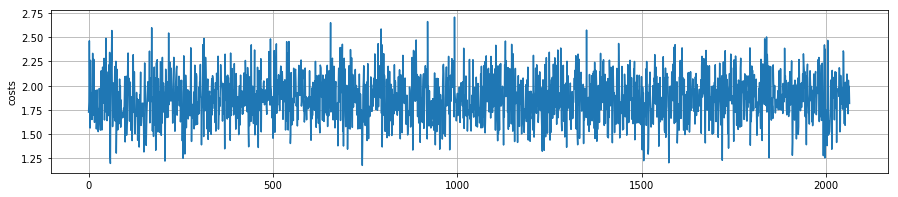

Target: <go>做愛其實很無聊打手槍比較爽<eos> Return: <go>有<unk>覺得另一半常常自己像對踏青<eos>
Target: <go>化工管理師越南<eos> Return: <go><go><unk><go><unk><eos>
Target: <go>美商light徵求機構工程師<eos> Return: <go><go>太平洋也這麼有成員<eos>
Target: <go>有人還記得<unk><unk>這本書嗎<eos> Return: <go>心愛男大叔徵友<eos>
Target: <go>愛的<unk>搶奧斯卡<unk>導演喝兩杯<eos> Return: <go>如何讓<go>女友知道<eos>
Target: <go>新竹交往對象<eos> Return: <go><unk>科技<eos>
Target: <go>過於信任是否反而不好<eos> Return: <go>11<go>的是甚麼<eos>
Target: <go>offer請益<eos> Return: <go>總老師師<eos>
Target: <go>狼與<unk>04<eos> Return: <go>我跟他徵女講的話一隻<eos>
Target: <go>捧王大陸<unk>4千萬<unk>坦言受打擊<eos> Return: <go>如何把精液外國化<eos>
Elapsed time in epoch 10: 4542 [s]

Elapsed time in total: 45745


In [63]:
import time
import random
import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.contrib import layers
import matplotlib
import matplotlib.pyplot as plt
################################################################
# Set parameter
################################################################
# batch parameter
build_new_model = True
patience = 0
num_epoch = 10
batch_size = 32
num_instances = len(y_train)
iter_per_epoch = num_instances // batch_size
test_num_instances = len(y_test)
test_iter_per_epoch = test_num_instances // batch_size
test_number = 10

# seq2seq parameter
limit_generation_len = max_title_length
embed_units_size = 300
rnn_size = 300
num_layers = 1
beam_width = 10

# regularization parameter
lstm_dropout = 0.5
l2_reg_const = 0.001

# optimization parameter
exp_decay_rate = 0.8
lr = 0.001
clip_const = 0.1

# helper parameter
only_train_helper = True
cos_decay_steps = num_epoch * 1 // 10 * iter_per_epoch
decoder_start_step = num_epoch * 1 // 10 * iter_per_epoch
decoder_end_step = num_epoch * 8 // 10 * iter_per_epoch

################################################################
# Load Embedding model
################################################################
def load_embed():
    embed_epoch = 40
    embed_name = 'PTT_Words_Embedding_1523903534.3398497'
    mdl_dir = os.path.join(base_dir, 'model')
    if not os.path.exists(mdl_dir):
        os.makedirs(mdl_dir)
    embed_dir = os.path.join(mdl_dir, embed_name)
    if not os.path.exists(embed_dir):
        os.makedirs(embed_dir)
    
    word2vector_graph = tf.Graph()
    with tf.Session(graph=word2vector_graph) as sess:
        ######## Load model parameters ########
        # Load model and weight parameters
        load_embed_dir = os.path.join(embed_dir, 'model-{}'.format(embed_epoch))
        loader = tf.train.import_meta_graph(load_embed_dir + '.meta')
        loader.restore(sess, load_embed_dir)
        # Load named input parameters
        embeddings = word2vector_graph.get_tensor_by_name('embeddings:0').eval()
        print('Embeddings lookup shape: ', embeddings.shape)
        norm = np.sqrt(np.sum(np.square(embeddings), 1, keepdims=True))
        normal_embeddings = embeddings / norm
    return embeddings, normal_embeddings

################################################################
# Build seq2seq model
################################################################
def model_input():
    ######## model input tensor ########
    is_training = tf.placeholder(tf.bool, (), name='is_training')
    is_decoder_in = tf.placeholder(tf.bool, (), name='is_decoder_in')
    is_time_major = tf.placeholder(tf.bool, (), name='is_time_major')
    inputs = tf.placeholder(tf.int32, (None, None), name='inputs')
    targets = tf.placeholder(tf.int32, (None, None), name='targets')
    input_seq_len = tf.placeholder(tf.int32, (None,), name='input_seq_len')
    target_seq_len = tf.placeholder(tf.int32, (None,), name='target_seq_len')
    limit_target_seq_len = tf.placeholder(tf.int32, (), name='limit_target_seq_len')
    input_batch_size = tf.shape(inputs)[0]
    return is_training, is_decoder_in, is_time_major, inputs, targets, input_seq_len, target_seq_len, limit_target_seq_len, input_batch_size
    
# LSTM cell
def get_rnn_cell(is_training, rnn_size, layer):
    rnn_cell = tf.contrib.rnn.LSTMCell(rnn_size, 
                initializer=tf.orthogonal_initializer(1.0, dtype=tf.float64))
                #initializer=tf.random_uniform_initializer(-1.0, 1.0, dtype=tf.float64))
    #rnn_cell = tf.contrib.rnn.GRUCell(rnn_size, 
                                      #kernel_initializer=tf.orthogonal_initializer(1.0, dtype=tf.float64))
    if is_training is not None and lstm_dropout < 1.0:
        if layer == 0:
            rnn_cell = tf.contrib.rnn.DropoutWrapper(rnn_cell, 
                                                      input_keep_prob=lstm_dropout, 
                                                      output_keep_prob=lstm_dropout)
        else:
            rnn_cell = tf.contrib.rnn.DropoutWrapper(rnn_cell, 
                                                      output_keep_prob=lstm_dropout)
    return rnn_cell
    
def embeddings_layer():
    ######## Build embedding layer weight. ########
    #embeddings = tf.constant(load_embed()[0], dtype=tf.float64)
    embeddings = tf.Variable(tf.random_uniform([vocab_size+1, embed_units_size], -1.0, 1.0, 
                                               dtype=tf.float64),name='embeddings')
    return embeddings

def encoder_layer(is_training, is_time_major, 
                inputs, input_seq_len, embeddings):
    ######## Build encoder layer weight. ########
    if is_time_major is not None:
        inputs = tf.transpose(inputs, [1, 0])
        time_major_bool = True
    else:
        time_major_bool = False
    encoder_embed_input = tf.nn.embedding_lookup(embeddings, inputs)
    
    # Struct encoder by LSTM multi-layer
    '''encoder_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(is_training, rnn_size, layer)
                                                  for layer in range(num_layers)])
    encoder_outputs, encoder_state = tf.nn.dynamic_rnn(encoder_cell, 
                                                       encoder_embed_input, 
                                                       sequence_length=input_seq_len, 
                                                       dtype=tf.float64, 
                                                       time_major=time_major_bool)
    '''
    # Struct encoder by LSTM bi-directional multi-layer
    encoder_f_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(is_training, rnn_size, layer)
                                                  for layer in range(num_layers)])
    encoder_b_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(is_training, rnn_size, layer)
                                                  for layer in range(num_layers)])
    encoder_bi_outputs, encoder_bi_state = tf.nn.bidirectional_dynamic_rnn(encoder_f_cell, 
                                                                           encoder_b_cell, 
                                                                           encoder_embed_input, 
                                                                           sequence_length=input_seq_len, 
                                                                           dtype=tf.float64, 
                                                                           time_major=time_major_bool)
    encoder_outputs = tf.concat((encoder_bi_outputs[0], encoder_bi_outputs[1]), 2)
    #encoder_state = tf.concat((encoder_bi_state[0], encoder_bi_state[1]), 2)
    encoder_state = tuple([tf.contrib.rnn.LSTMStateTuple(tf.concat((state_f.c, state_b.c), 1), 
                                                          tf.concat((state_f.h, state_b.h), 1))
                     for state_f, state_b in zip(encoder_bi_state[0], encoder_bi_state[1])])
    
    return encoder_outputs, encoder_state

def attention_layer(is_training, is_time_major, 
                    encoder_outputs, encoder_state, 
                    input_seq_len, input_batch_size):
    ######## Build attention layer weight. ########
    if is_time_major is not None:
        encoder_outputs = tf.transpose(encoder_outputs, [1, 0, 2])
    
    # Struct LSTM cell in Decoder
    multi_rnn_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(is_training, rnn_size*2, layer)
                                                for layer in range(num_layers)])
    
    '''# For beam search decoder
    encoder_outputs = tf.contrib.seq2seq.tile_batch(
        encoder_outputs, multiplier=beam_width)
    input_seq_len = tf.contrib.seq2seq.tile_batch(
        input_seq_len, multiplier=beam_width)
    encoder_state = tf.contrib.seq2seq.tile_batch(
        encoder_state, multiplier=beam_width)
    input_batch_size = input_batch_size * beam_width
    '''
    #attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(rnn_size*2, encoder_outputs,
    attention_mechanism = tf.contrib.seq2seq.LuongAttention(rnn_size*2, encoder_outputs,
                                                            memory_sequence_length=input_seq_len,
                                                            dtype=tf.float64)
    decoder_cell = tf.contrib.seq2seq.AttentionWrapper(multi_rnn_cell, 
                                                       attention_mechanism, 
                                                       attention_layer_size=rnn_size)
    decoder_ini_state = decoder_cell.zero_state(input_batch_size,
                                                tf.float64).clone(cell_state=encoder_state)
    return decoder_ini_state, decoder_cell

'''def decoder_layer(is_training, is_decoder_in, is_time_major, 
                  targets, target_seq_len, limit_target_seq_len, 
                  decoder_ini_state, decoder_cell, 
                  input_batch_size, embeddings):
    if is_time_major is not None:
        time_major_bool = True
    else:
        time_major_bool = False
    
    # Output fully-connecting layer
    projection_layer = Dense(vocab_size+1, use_bias=False,
                         kernel_initializer=tf.truncated_normal_initializer(
                             mean=0.0, stddev=0.1, dtype=tf.float64))
    
    # Struct training decoder (Share variable with predicting)
    start_tokens = tf.tile(tf.constant([vocab[GO_id]], dtype=tf.int32),
                           [input_batch_size * beam_width], name='start_tokens')
    # Define a beam-search decoder
    rnn_decoder = tf.contrib.seq2seq.BeamSearchDecoder(
        cell=decoder_cell,
        embedding=embeddings,
        start_tokens=start_tokens,
        end_token=vocab[EOS_id],
        initial_state=decoder_initial_state,
        beam_width=beam_width,
        projection_layer=projection_layer,
        length_penalty_weight=0.0)
    
    decoder_output, _, training_seq_len = tf.contrib.seq2seq.dynamic_decode(
        rnn_decoder, impute_finished=True, maximum_iterations=limit_target_seq_len)
    
    translations = outputs.predicted_ids
    # Make sure translations shape is [batch_size, beam_width, time]
    if is_time_major is not None:
        translations = tf.transpose(translations, perm=[1, 2, 0])

    ######## Model output tensor ########
    training_logits = tf.identity(decoder_output.rnn_output, name='training_logits')
    training_ids = tf.identity(decoder_output.sample_id, name='training_ids')
    max_training_seq_len = tf.reduce_max(training_seq_len)
    return training_logits, training_ids, max_training_seq_len'''

def decoder_layer(is_training, is_decoder_in, is_time_major, 
                  targets, target_seq_len, limit_target_seq_len, 
                  decoder_ini_state, decoder_cell, 
                  input_batch_size, embeddings):
    ######## Build decoder layer weight. ########
    if is_time_major is not None:
        time_major_bool = True
    else:
        time_major_bool = False
    
    # Output fully-connecting layer
    projection_layer = Dense(vocab_size+1, use_bias=False,
                         kernel_initializer=tf.truncated_normal_initializer(
                             mean=0.0, stddev=0.1, dtype=tf.float64))
    
    # Struct training decoder (Share variable with predicting)
    if is_decoder_in is not None:
        if is_time_major is not None:
            targets = tf.transpose(targets, [1, 0])
        decoder_embed_input = tf.nn.embedding_lookup(embeddings, targets)
        training_helper = tf.contrib.seq2seq.TrainingHelper(
            decoder_embed_input, target_seq_len, time_major=time_major_bool)
    else:
        start_tokens = tf.tile(tf.constant([vocab[GO_id]], dtype=tf.int32),
                               [input_batch_size], name='start_tokens')
        training_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
            embeddings, start_tokens, vocab[EOS_id])

    training_decoder = tf.contrib.seq2seq.BasicDecoder(
        decoder_cell, training_helper, decoder_ini_state, projection_layer) 
    training_output, _, training_seq_len = tf.contrib.seq2seq.dynamic_decode(
        training_decoder, impute_finished=True, maximum_iterations=limit_target_seq_len)
    
    ######## Model output tensor ########
    training_logits = tf.identity(training_output.rnn_output, name='training_logits')
    training_ids = tf.identity(training_output.sample_id, name='training_ids')
    max_training_seq_len = tf.reduce_max(training_seq_len)
    return training_logits, training_ids, max_training_seq_len
    
def loss_function(training_logits, targets, target_seq_len, max_seq_len):
    ######## Build loss function ########
    masks = tf.sequence_mask(target_seq_len, max_seq_len, dtype=tf.float64)
    cost = tf.contrib.seq2seq.sequence_loss(training_logits, targets, masks, name='sequence_cost')
    return cost
    
def optimization(cost):
    ######## Build optimization ########
    # Add regularization to Loss
    lossL2 = tf.Variable(0.0, trainable=False, dtype=tf.float64)
    #regularization_loss = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
    lossL2 = l2_reg_const * sum( tf.nn.l2_loss(var)
                                for var in tf.trainable_variables() if not ('Bias' in var.name))
    
    # Optimizer
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(
        lr, global_step, iter_per_epoch, exp_decay_rate, staircase=False)
    global_step = global_step + 1
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-12)
    
    # Gradient Clipping
    gradients, vriables = zip(*optimizer.compute_gradients(cost+lossL2))
    gradients = [None if gradient is None else tf.clip_by_norm(gradient, clip_const)
                 for gradient in gradients]
    train_step = optimizer.apply_gradients(zip(gradients, vriables), name='train_step')
    return train_step

################################################################
# Prepare to run session
################################################################
total_start_t = time.time()
if build_new_model:
    str_epoch = 0
    decoder_global_step = 0
    model_name = 'PTT_Encoder-Decoder_model_fixed_' + str(total_start_t)
else:
    str_epoch = 1
    decoder_global_step = str_epoch * iter_per_epoch
    model_name = 'PTT_Encoder-Decoder_model_fixed_1524077398.2482338'

iter_pct10 = iter_per_epoch // 10
if (num_instances % batch_size) > 0:
    iter_per_epoch += 1
batch_cutoff = [0]
for i in range(iter_per_epoch - 1):
    batch_cutoff.append(batch_size * (i+1))
batch_cutoff.append(num_instances)
costs_list = []

best_costs_mean = 0.0
early_stop_counter = 0
last_loss = 0.0
last_rnn_output = 0.0
last_train_op = 0.0
################################################################
# Run model session
################################################################
train_graph = tf.Graph()
if build_new_model:
    ######## Build model parameters ########
    with train_graph.as_default():
        # Build input parameters
        is_training, is_decoder_in, is_time_major, inputs, targets, input_seq_len, target_seq_len, limit_target_seq_len, input_batch_size = model_input()
        # Build model and weight parameters
        embeddings = embeddings_layer()
        encoder_outputs, encoder_state = encoder_layer(
            is_training, is_time_major,
            inputs, input_seq_len, embeddings)
        decoder_ini_state, decoder_cell = attention_layer(
            is_training, is_time_major, 
            encoder_outputs, encoder_state, 
            input_seq_len, input_batch_size)
        training_logits, training_ids, training_seq_len = decoder_layer(
            is_training, is_decoder_in, is_time_major, 
            targets, target_seq_len, limit_target_seq_len, 
            decoder_ini_state, decoder_cell, 
            input_batch_size, embeddings)
        # Build optimizer
        cost = loss_function(training_logits, targets, target_seq_len, training_seq_len)
        train_step = optimization(cost)

with tf.Session(graph=train_graph) as sess:
    if build_new_model:
        sess.run(tf.global_variables_initializer())
        best_epoch = 1
    else:
        ######## Load model parameters ########
        # Load model and weight parameters
        best_epoch = str_epoch
        load_model_dir = os.path.join(model_dir, 'model-{}'.format(str_epoch))
        loader = tf.train.import_meta_graph(load_model_dir + '.meta')
        loader.restore(sess, load_model_dir)
        # Load named input parameters
        is_training = train_graph.get_tensor_by_name('is_training:0')
        is_decoder_in = train_graph.get_tensor_by_name('is_decoder_in:0')
        is_time_major = train_graph.get_tensor_by_name('is_time_major:0')
        inputs = train_graph.get_tensor_by_name('inputs:0')
        targets = train_graph.get_tensor_by_name('targets:0')
        input_seq_len = train_graph.get_tensor_by_name('input_seq_len:0')
        target_seq_len = train_graph.get_tensor_by_name('target_seq_len:0')
        limit_target_seq_len = train_graph.get_tensor_by_name('limit_target_seq_len:0')
        # Load named output and optimizer parameters
        predicting_ids = train_graph.get_tensor_by_name('predicting_ids:0')
        training_logits = train_graph.get_tensor_by_name('training_logits:0')
        training_ids = train_graph.get_tensor_by_name('training_ids:0')
        cost = train_graph.get_tensor_by_name('sequence_cost/truediv:0')
        train_step = train_graph.get_operation_by_name('train_step')
    
    ######## Run model epoch ########
    for e in range(str_epoch,str_epoch+num_epoch):
        rand_idxs = np.random.permutation(num_instances)
        print('\n========')
        print('epoch' + str(e+1))
        print('========')
        start_t = time.time()
        costs = []
        
        ######## Get random input batch and training model. ########
        for i in range(iter_per_epoch):
            X_batch = []
            Y_batch = []
            X_size = []
            Y_size = []
            for n in range(batch_cutoff[i],batch_cutoff[i+1]):
                X_batch.append(x_train[rand_idxs[n]])
                Y_batch.append(y_train[rand_idxs[n]])
                X_size.append(x_train_size[rand_idxs[n]])
                Y_size.append(y_train_size[rand_idxs[n]])
            X_size_max = max(X_size)
            Y_size_max = max(Y_size)
            X_batch = np.array(X_batch)
            Y_batch = np.array(Y_batch)
            X_size = np.array(X_size)
            Y_size = np.array(Y_size)
            
            # Select helper based on learning time.
            '''decoder_random = np.random.uniform(0.0, 1.0)
            decoder_global_step = min(decoder_global_step, decoder_end_step)
            decoder_step = max(decoder_global_step - decoder_start_step, 0)
            helper_rate = 0.5 * (1.0 + np.cos(np.pi * decoder_step / (decoder_end_step - decoder_start_step)))
            '''
            decoder_global_step +=1
            if decoder_random<helper_rate or only_train_helper:
                feed_dict = {is_training: True, is_decoder_in: True, is_time_major: True,
                     inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                     input_seq_len: X_size, target_seq_len: Y_size,
                     limit_target_seq_len: limit_generation_len}
            else:
                feed_dict = {is_training: True, is_time_major: True,
                     inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                     input_seq_len: X_size, target_seq_len: Y_size,
                     limit_target_seq_len: limit_generation_len}
            
            if (i + 1) % iter_pct10 == 0:
                train_op, loss, output_ids = sess.run(
                    [train_step, cost, training_ids], feed_dict)
            else:
                train_op, loss = sess.run(
                    [train_step, cost], feed_dict)
            
            if np.isnan(loss):
                print('\n!!!! Loss is NaN! !!!!')
                print('NaN epoch: ', e, ' ; NaN iteration: ', i+1)
                print('Stop decoder_global_step: ', decoder_global_step)
                print('The last loss: ', last_loss)
                break
            else:
                costs.append(loss)
                last_loss = loss
                last_rnn_output = rnn_output
                last_train_op = train_op
            
            if (i + 1) % iter_pct10 == 0:
                if e==0:
                    mdl_dir = os.path.join(base_dir, 'model')
                    if not os.path.exists(mdl_dir):
                        os.makedirs(mdl_dir)
                    model_dir = os.path.join(mdl_dir, model_name)
                    if not os.path.exists(model_dir):
                        os.makedirs(model_dir)
                
                costs_pct10 = np.array(costs[-iter_pct10:])
                log = 'Iteration {}({}%); Train loss: {} (std: {}); run time: {}[s]'.format(
                    str(i+1), str(round(i*100/iter_per_epoch,2)),
                    str(costs_pct10.mean()), str(costs_pct10.std()),
                    str(int(time.time() - start_t)))
                print(log)
                log += '\n'
                for batch_index in range(batch_size):
                    log += 'Target: {}'.format("".join([vocab_reverse[i] for i in Y_batch[batch_index] if i != 0]))
                    log += '; Return: {}'.format("".join([vocab_reverse[i] for i in output_ids[batch_index] if i != 0]))
                    log += '\n'
                else:
                    with open(os.path.join(model_dir, 'Target_Return.txt'),
                            'a', encoding = 'utf-8-sig') as file:
                        file.write('Epoch' + str(e+1) + '\n' + log + '\n')
        
        ######## Save model weight parameters and information. ########
        costs_mean = np.array(costs).mean()
        print('Train Loss: ', costs_mean)
        if costs_mean < best_costs_mean or e == 0:
            best_costs_mean = costs_mean
            best_epoch = e
            early_stop_counter = 0
            print('Save best score!! '+str(best_costs_mean))
        else:
            early_stop_counter += 1
            print('Count early stop!! '+str(early_stop_counter))
        
        model_path = os.path.join(model_dir, 'model-%d' %(e+1))
        saver = tf.train.Saver()
        saver.save(sess, model_path)
        
        ######## Print cost curve of this epoch. ########
        costs_list.append(costs)
        plt.figure(figsize=(15,3))
        plt.plot(costs)
        plt.ylabel('costs')
        plt.grid()
        plt.show()
        
        ######## Generate title form testing content and validating model. ########
        Xt_batch = []
        Yt_batch = []
        Xt_size = []

        for _ in range(test_number):
            n = random.randint(0, test_num_instances-1)
            Xt_batch.append(x_test[n])
            Yt_batch.append(y_test[n])
            Xt_size.append(x_test_size[n])
        Xt_size_max = max(Xt_size)
        Xt_batch = np.array(Xt_batch)
        Yt_batch = np.array(Yt_batch)
        Xt_size = np.array(Xt_size)
            
        feed_dict = {is_time_major: True,
                     inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                     input_seq_len: X_size, target_seq_len: Y_size,
                     limit_target_seq_len: limit_generation_len}
        answer_ids = sess.run(training_ids, feed_dict)
        for n in range(test_number):
            log = 'Target: {}'.format("".join([vocab_reverse[i] for i in Yt_batch[n] if i != 0]))
            print(log + ' Return: {}'.format("".join([vocab_reverse[i] for i in answer_ids[n] if i != 0])))
        
        print('Elapsed time in epoch ' + str(e+1) + ': ' + str(int(time.time() - start_t)) + ' [s]')
        
        if patience != 0 and early_stop_counter >= patience:
            print('\n#######')
            print('Best model')
            print('#######')
            print('Stop by early stopping')
            print('Best score: ', best_costs_mean, 'Beat model: ', best_epoch)
            break

print('\nElapsed time in total: ' + str(int(time.time() - total_start_t)))

In [65]:
import os
import random
################################
#Generate title form testing content and validating model. 
################################
base_dir = 'C:/Users/User/Raw data/PTT'
model_name = 'PTT_Encoder-Decoder_model_fixed_1524129573.4022381'
epoch = 10
model_path = os.path.join(base_dir, 'model', model_name, 'model-{}'.format(epoch))
print('Test epoch: ', epoch)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(model_path + '.meta')
    loader.restore(sess, model_path)
    # Named parameters
    #is_training = loaded_graph.get_tensor_by_name('is_training:0')
    is_training = loaded_graph.get_tensor_by_name('is_training:0')
    is_decoder_in = loaded_graph.get_tensor_by_name('is_decoder_in:0')
    is_time_major = loaded_graph.get_tensor_by_name('is_time_major:0')
    inputs = loaded_graph.get_tensor_by_name('inputs:0')
    targets = loaded_graph.get_tensor_by_name('targets:0')
    input_seq_len = loaded_graph.get_tensor_by_name('input_seq_len:0')
    target_seq_len = loaded_graph.get_tensor_by_name('target_seq_len:0')
    limit_target_seq_len = loaded_graph.get_tensor_by_name('limit_target_seq_len:0')
    # Load named output and optimizer parameters
    training_logits = loaded_graph.get_tensor_by_name('training_logits:0')
    training_ids = loaded_graph.get_tensor_by_name('training_ids:0')
    cost = loaded_graph.get_tensor_by_name('sequence_cost/truediv:0')
    train_step = loaded_graph.get_operation_by_name('train_step')
    
    for _ in range(10):
        i_str = random.randint(0,test_num_instances-1)
        i_end = i_str + 1

        X_batch = np.tile(x_test[i_str], (batch_size, 1))
        Y_batch = np.tile(y_test[i_str], (batch_size, 1))
        X_size = np.tile(x_test_size[i_str], (batch_size))
        Y_size = np.tile(y_test_size[i_str], (batch_size))
        max_X_size = x_test_size[i_str]
        max_Y_size = y_test_size[i_str]
        '''answer_ids = sess.run( logits, {inputs: X_batch, targets: Y_batch, 
                                             input_seq_len: X_size, target_seq_len: Y_size,
                                             limit_target_seq_len: limit_generation_len})'''
        feed_dict = {is_time_major: True,
                     inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                     input_seq_len: X_size, target_seq_len: Y_size,
                     limit_target_seq_len: limit_generation_len}
        answer_ids = sess.run(training_ids, feed_dict)

        output_index = 0 #random.randint(0,batch_size-1)
        print('\n========')
        print('Test index: ', i_str + output_index)
        print('========')
        print('Test input Words: {}'.format("".join([vocab_reverse[i] for i in X_batch[output_index] if i != 0])))
        print('Target Words: {}'.format("".join([vocab_reverse[i] for i in Y_batch[output_index] if i != 0])))
        print('Response Words: {}'.format("".join([vocab_reverse[i] for i in answer_ids[output_index] if i != 0])))

Test epoch:  10
INFO:tensorflow:Restoring parameters from C:/Users/User/Raw data/PTT\model\PTT_Encoder-Decoder_model_fixed_1524129573.4022381\model-10

Test index:  3121
Test input Words: <go>全球最大半導體<unk>應用材料全球副總裁<unk>昨6日表示應用材料推出<unk><unk><unk>化學<unk><unk><unk><unk>金屬系統解除<unk>技術瓶頸讓摩爾定律持續往下<unk>至20奈米以下製程他表示由於晶圓製造技術突破2014年是晶圓代工20奈米及3dnand起飛量產年應用材料宣布推出<unk><unk>化學<unk><unk><unk>金屬系統<unk>台是市面上唯一能<unk>精密的<unk>金屬薄膜為28奈米以下的邏輯晶片提供<unk><unk>包覆的能力能夠解除<unk>技術瓶頸讓摩爾定律持續往下<unk>同時應用材料<unk><unk>物理<unk><unk><unk>系統也能協助客戶降低成本利用<unk><unk><unk><unk>技術來生產尺寸更小<unk>更低整合度更高的3d晶片<eos>
Target Words: <go>應材新系統<unk>製造起飛<eos>
Response Words: <go>帶線新系統<unk>製造<go><eos>

Test index:  642
Test input Words: <go>大家好這裏是實況<unk>緊張的第一次看到<unk>的噩夢後突然很想實況於是就試著做了自己開始做實況後才發現要弄出一個正常的影片真的是很麻煩呢光測試麥克風跟音量比例就一個晚上過去了orz一直掙扎在各種技術問題上我果然是手殘啊嗚嗚而且熬夜錄遊戲實況聽起來真是<unk>不行啊囧那麼下面是水管網址抱歉沒有字幕也沒有剪接跟特效努力學習<unk>多多指教鞠躬ps因為忘了調整體幅度結果好像變很小聲大家可能要稍微調大聲一點max之類的欸我下次會注意這點的<unk>話<unk>了整段的碎<unk>發現原來自己的聲音聽起來這麼嫩xd像嬌小的女孩會有的聲音好希望本人也這麼可愛啊結果變成忍不住自己一直<unk>不停自己刷次數xd<eos>
